<a href="https://colab.research.google.com/github/jiiwons/study/blob/main/MNIST_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST 데이터 준비

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


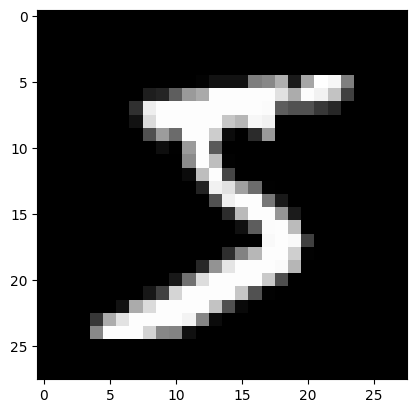

In [ ]:
# image reshape
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# Colab이 아닌 경우에만 ``pyplot.show()``
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [ ]:
# PyTorch는 NumPy 배열 보다는 torch.tensor 를 사용하므로, 데이터를 변환해야함
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## (torch.nn 없이) 밑바닥부터 신경망 만들기

In [ ]:
# 가중치 초기화
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [ ]:
# 활성화 함수
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# 행렬 곱셈 연산, 하나의 배치데이터에 대하여 이 함수를 호출(forward pass)
def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64  # 배치 크기

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape) # preds 텐서는 grad_fn(기울기 함수)를 담고 있음(역전파에 사용)

tensor([-2.1798, -1.9692, -2.5183, -2.3790, -2.4429, -2.0935, -2.5150, -2.2812,
        -2.1916, -2.6707], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [ ]:
# 손실 함수로서, 음의 로그 우도(negative log-likelihood) 구현
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3852, grad_fn=<NegBackward0>)


In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
print(accuracy(preds, yb))

tensor(0.1250)


훈련 루프(training loop)를 실행


*   데이터의 미니배치를 선택 (bs 크기)
*   모델을 이용하여 예측 수행
*   손실 계산
*   loss.backward() 를 이용하여 모델의 기울기 업데이트, 이 경우에는, weights 와 bias




In [ ]:
# 기울기들을 이용하여 가중치와 절편을 업데이트
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0809, grad_fn=<NegBackward0>) tensor(1.)


## torch.nn.functional 사용하기

In [ ]:
# 앞에서 직접 작성한 활성화, 손실함수를 torch.nn.functional 의 함수로 대체

# def log_softmax(x):
#     return x - x.exp().sum(-1).log().unsqueeze(-1)
# def model(xb):
#     return log_softmax(xb @ weights + bias)

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward0>) tensor(1.)


## nn.Module 을 이용하여 리팩토링 하기

포워드 단계에 대한 가중치, 절편, 그리고 메소드 등을 유지하는 클래스를 만듦

In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [ ]:
# 함수 대신 오브젝트를 사용하기 때문에 모델을 인스턴스화해야됨
model = Mnist_Logistic()

In [ ]:
print(loss_func(model(xb), yb))

tensor(2.3229, grad_fn=<NllLossBackward0>)


In [ ]:
# 이전 방법
# 이름 별로 각 매개변수(parameter)의 값을 업데이트, 기울기를 수동으로 0으로 제거했어야함
# with torch.no_grad():
#     weights -= weights.grad * lr
#     bias -= bias.grad * lr
#     weights.grad.zero_()
#     bias.grad.zero_()

In [ ]:
# model.parameters() 및 model.zero_grad()를 활용하여 코드 간결화
with torch.no_grad():
    for p in model.parameters():
        if p.grad is not None:
            p -= p.grad * lr
    model.zero_grad()

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [ ]:
print(loss_func(model(xb), yb))

tensor(0.0830, grad_fn=<NllLossBackward0>)


## nn.Linear 를 사용하여 리팩토링 하기

self.weights, self.bias를 수동으로 정의 및 초기화함<br>
xb @ self.weights + self.bias 를 계산하는 대신에, 위의 모든 것을 해주는 nn.Linear를 선형 레이어로 사용

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2461, grad_fn=<NllLossBackward0>)


In [ ]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward0>)


## torch.optim 을 이용하여 리팩토링 하기

torch.optim : 다양한 최적화 알고리즘을 가진 패키지<br>
각 매개변수를 수동으로 업데이트 하는 대신, 옵티마이저의 step메소드를 사용하여 업데이트를 진행함

In [ ]:
# 이전 방법, 수동으로 코딩한 최적화 단계
# with torch.no_grad():
#     for p in model.parameters():
#         if p.grad is not None:
#             p -= p.grad * lr
#     model.zero_grad()

In [ ]:
# 이전에 수동으로 코딩한 최적화 단계를 대체함
opt.step()
opt.zero_grad()

In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2555, grad_fn=<NllLossBackward0>)
tensor(0.0835, grad_fn=<NllLossBackward0>)


## Dataset 을 이용하여 리팩토링하기

In [ ]:
from torch.utils.data import TensorDataset
#PyTorch의 TensorDataset은 텐서를 감싸는 Dataset.
#길이와 인덱싱 방식을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스 하는 방법도 제공함

In [ ]:
train_ds = TensorDataset(x_train, y_train)

In [ ]:
# 이전 방법
# xb = x_train[start_i:end_i]
# yb = y_train[start_i:end_i]

In [ ]:
# 이젠 두 단계를 함께 수행할 수 있음
xb,yb = train_ds[i*bs : i*bs+bs]

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward0>)


## DataLoader 를 사용하여 리팩토링하기

DataLoader는 배치들에 대해서 반복하기 쉽게 만들어주며, 매 미니배치를 자동적으로 제공

In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [ ]:
# 이전 방법, 루프가 배치(xb, yb)를 반복했음
# for i in range((n-1)//bs + 1):
#     xb,yb = train_ds[i*bs : i*bs+bs]
#     pred = model(xb)

In [ ]:
# 이젠 (xb, yb)가 DataLoader 에서 자동으로 로드됨
for xb,yb in train_dl:
    pred = model(xb)

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward0>)


## 검증(validation) 추가하기

In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)# 훈련 데이터를 섞는 것은 배치와 과적합 사이의 상관관계를 방지하므로 True

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2) # 검증 손실은 섞든 안섞든 동일
                                                   # 검증 데이터셋에 대한 배치 크기는 학습 데이터셋 배치 크기의 2배를 사용, 더 큰 배치 크기를 사용하여 손실을 더 빨리 계산

In [ ]:
# 각 에폭이 끝날 때 검증 손실을 계산하고 프린트
# nn.BatchNorm2d 및 nn.Dropout과 같은 레이어에서 다른 단계(훈련, 추론)에 대한 적절한 동작이 일어나게 하기 위해서
# 훈련 전에 항상 model.train()을 호출하고, 추론 전에 model.eval()을 호출함
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3119)
1 tensor(0.3420)


## fit() 와 get_data() 생성하기

In [ ]:
# 훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두번 거치므로,
# 하나의 배치에 대한 손실을 계산하는 자체 함수 loss_batch를 만듦
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
# 모델을 훈련하고 각 에폭에 대한 훈련 및 검증 손실을 계산하는 작업 수행
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.29390495007038114
1 0.28614960790872573


## CNN 으로 넘어가기

In [ ]:
# Pytorch의 사전정의된 Conv2d 클래스를 컨볼루션 레이어로 사용
# 각 컨볼루션 뒤에는 ReLU가 있으며, 마지막으로 평균 폴링(avg_pool2d)을 수행
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [ ]:
# 모멘텀- 확률적 경사하강법의 변형
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3380568027973175
1 0.24161086231470108


## nn.Sequential 사용하기

Sequential 객체는 그 안에 포함된 각 모듈을 순차적으로 실행함

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32358564591407774
1 0.22571789053082467


## DataLoader 감싸기

In [ ]:
# 모델이 모든 2d 단일 채널(channel) 이미지에서 작동하도록
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
## nn.AvgPool2d 를 nn.AdaptiveAvgPool2d 로 대체, 출력 텐서의 크기를 정의할 수 있음
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3230719187259674
1 0.2417633773982525


## GPU 사용하기

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.19300037670731546
1 0.28820842316150663


- torch.nn:
  - Module: 함수처럼 동작하지만, 또한 상태(state) (예를 들어, 신경망의 레이어 가중치)를 포함할 수 있는 호출 가능한 오브젝트를 생성합니다. 이는 포함된 Parameter (들)가 어떤 것인지 알고, 모든 기울기를 0으로 설정하고 가중치 업데이트 등을 위해 반복할 수 있습니다.

  - Parameter: Module 에 역전파 동안 업데이트가 필요한 가중치가 있음을 알려주는 텐서용 래퍼입니다. requires_grad 속성이 설정된 텐서만 업데이트 됩니다.

  - functional: 활성화 함수, 손실 함수 등을 포함하는 모듈 (관례에 따라 일반적으로 F 네임스페이스로 임포트 됩니다) 이고, 물론 컨볼루션 및 선형 레이어 등에 대해서 상태를 저장하지않는(non-stateful) 버전의 레이어를 포함합니다.

- torch.optim: 역전파 단계에서 Parameter 의 가중치를 업데이트하는, SGD 와 같은 옵티마이저를 포함합니다.

- Dataset: TensorDataset 과 같이 PyTorch와 함께 제공되는 클래스를 포함하여 __len__ 및 __getitem__ 이 있는 객체의 추상 인터페이스

- DataLoader: 모든 종류의 Dataset 을 기반으로 데이터의 배치들을 출력하는 반복자(iterator)를 생성합니다.